# Stock Market Prediction using Numerical and Textual Analysis

Satyam Kushwaha
Task_7 GRIP_Batch - July_2022

Dataset - 'https://bit.ly/36fFPI6'

Objective : Create a hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines

Stock to analyze and predict - SENSEX (S&P BSE SENSEX)

In [75]:
# importing required libraries
import warnings
warnings.filterwarnings('ignore')
import time
import datetime

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation

In [48]:
# Make a request call to Yahoo Finance's back-end to access the stock data and export them as CSV files
ticker = 'TSLA'
period1 = int(time.mktime(datetime.datetime(2022, 1, 1, 23, 59).timetuple()))
period2 = int(time.mktime(datetime.datetime(2022, 7, 1, 23, 59).timetuple())) 
interval = '1d' # 1wk, 1m

In [49]:
query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'

In [50]:
history_stock = pd.read_csv(query_string)

In [51]:
history_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       125 non-null    object 
 1   Open       125 non-null    float64
 2   High       125 non-null    float64
 3   Low        125 non-null    float64
 4   Close      125 non-null    float64
 5   Adj Close  125 non-null    float64
 6   Volume     125 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 7.0+ KB


In [52]:
txt_data = pd.read_csv('india-news-headlines.csv')

In [53]:
txt_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650970 entries, 0 to 3650969
Data columns (total 3 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   publish_date       int64 
 1   headline_category  object
 2   headline_text      object
dtypes: int64(1), object(2)
memory usage: 83.6+ MB


In [54]:
history_stock.isna().any()

Date         False
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

In [55]:
txt_data.isna().any()

publish_date         False
headline_category    False
headline_text        False
dtype: bool

# Stock

In [56]:
import nltk
nltk.download('vader_lexicon')
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [57]:
#dropping any null entries in history_stock dataset
#history_stock.dropna(axis=0, inplace = True)

In [58]:
 #dropping duplicates in data
#history_stock = history_stock.drop_duplicates()

# coverting the datatype of column 'Date' from type object to type 'datetime'
history_stock['Date'] = pd.to_datetime(history_stock['Date']).dt.normalize()

# filtering the important columns
history_stock = history_stock.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

# setting column 'Date' as the index column
history_stock.set_index('Date', inplace= True)

# sorting the data according to Date
history_stock = history_stock.sort_index(ascending=True, axis=0)

In [59]:
history_stock

,Close,Open,High,Low,Volume
Date,,,,,
2022-01-03,1199.780029,1147.750000,1201.069946,1136.040039,34643800
2022-01-04,1149.589966,1189.550049,1208.000000,1123.050049,33416100
2022-01-05,1088.119995,1146.650024,1170.339966,1081.010010,26706600
2022-01-06,1064.699951,1077.000000,1088.000000,1020.500000,30112200
2022-01-07,1026.959961,1080.369995,1080.930054,1010.000000,28054900
...,...,...,...,...,...
2022-06-27,734.760010,748.099976,756.210022,727.700012,29726100
2022-06-28,697.989990,733.450012,749.909973,697.030029,30130400
2022-06-29,685.469971,691.500000,693.520020,666.820007,27632400


# Textual_data

In [60]:
# dropping duplicates
txt_data = txt_data.drop_duplicates()

# coverting the datatype of column 'Date' from type string to type 'datetime'
txt_data['publish_date'] = txt_data['publish_date'].astype(str)
txt_data['publish_date'] = txt_data['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
txt_data['publish_date'] = pd.to_datetime(txt_data['publish_date']).dt.normalize()

# filtering the important columns 
txt_data = txt_data.filter(['publish_date', 'headline_text'])

# grouping the news headlines according to Date
txt_data = txt_data.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

# setting Date as the index column
txt_data.set_index('publish_date', inplace= True)

# sorting the data according to the Date
txt_data = txt_data.sort_index(ascending=True, axis=0)

In [61]:
txt_data

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2022-03-27,Playing a dead man in Body God meant sitting i...
2022-03-28,As fashion becomes democratic; demand for styl...
2022-03-29,Bobby Deol: Like my dad; I hope to be working ...


# Combining both dataset

In [62]:
comb_stock_data = pd.concat([history_stock, txt_data], axis =1)

In [63]:
comb_stock_data

,Close,Open,High,Low,Volume,headline_text
2001-01-02,NaN,NaN,NaN,NaN,NaN,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,NaN,NaN,NaN,NaN,NaN,"Powerless north India gropes in the dark,Think..."
2001-01-04,NaN,NaN,NaN,NaN,NaN,The string that pulled Stephen Hawking to Indi...
2001-01-05,NaN,NaN,NaN,NaN,NaN,Light combat craft takes India into club class...
2001-01-06,NaN,NaN,NaN,NaN,NaN,Light combat craft takes India into club class...
...,...,...,...,...,...,...
2022-06-27,734.760010,748.099976,756.210022,727.700012,29726100.0,NaN
2022-06-28,697.989990,733.450012,749.909973,697.030029,30130400.0,NaN
2022-06-29,685.469971,691.500000,693.520020,666.820007,27632400.0,NaN
2022-06-30,673.419983,673.530029,688.369995,656.590027,31533500.0,NaN


In [64]:
comb_stock_data.dropna(axis = 0, inplace = True)

In [65]:
comb_stock_data

,Close,Open,High,Low,Volume,headline_text
2022-01-03,1199.780029,1147.750000,1201.069946,1136.040039,34643800.0,Horoscope Today; 3 January 2022: Check astrolo...
2022-01-04,1149.589966,1189.550049,1208.000000,1123.050049,33416100.0,Horoscope Today; 4 January 2022: Check astrolo...
2022-01-05,1088.119995,1146.650024,1170.339966,1081.010010,26706600.0,Horoscope Today; 5 January 2022: Check astrolo...
2022-01-06,1064.699951,1077.000000,1088.000000,1020.500000,30112200.0,Horoscope Today; 6 January 2022: Check astrolo...
2022-01-07,1026.959961,1080.369995,1080.930054,1010.000000,28054900.0,Horoscope Today; 7 January 2022: Check astrolo...
...,...,...,...,...,...,...
2022-03-25,1010.640015,1008.000000,1021.799988,997.320007,20677200.0,Speeding up; shortcuts and tackling unruly cus...
2022-03-28,1091.839966,1065.099976,1097.880005,1053.599976,34168700.0,As fashion becomes democratic; demand for styl...
2022-03-29,1099.569946,1107.989990,1114.770020,1073.109985,24538300.0,Bobby Deol: Like my dad; I hope to be working ...
2022-03-30,1093.989990,1091.170044,1113.949951,1084.000000,19955000.0,"I will not give in to trends: Dossmode,The tim..."


In [66]:
#Sentiment Analysis
comb_stock_data['compound'] = ''
comb_stock_data['negative'] = ''
comb_stock_data['neutral'] = ''
comb_stock_data['positive'] = ''
comb_stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2022-01-03,1199.780029,1147.750000,1201.069946,1136.040039,34643800.0,Horoscope Today; 3 January 2022: Check astrolo...,,,,
2022-01-04,1149.589966,1189.550049,1208.000000,1123.050049,33416100.0,Horoscope Today; 4 January 2022: Check astrolo...,,,,
2022-01-05,1088.119995,1146.650024,1170.339966,1081.010010,26706600.0,Horoscope Today; 5 January 2022: Check astrolo...,,,,
2022-01-06,1064.699951,1077.000000,1088.000000,1020.500000,30112200.0,Horoscope Today; 6 January 2022: Check astrolo...,,,,
2022-01-07,1026.959961,1080.369995,1080.930054,1010.000000,28054900.0,Horoscope Today; 7 January 2022: Check astrolo...,,,,


In [67]:
#

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

#Sentiment Analyzer
sia = SentimentIntensityAnalyzer()
print('Start calculating sentiment scores:')

comb_stock_data['compound'] = comb_stock_data['headline_text'].apply(lambda x: sia.polarity_scores(x)['compound'])
print('Compound Done')
comb_stock_data['negative'] = comb_stock_data['headline_text'].apply(lambda x: sia.polarity_scores(x)['neg'])
print('Negative Done')
comb_stock_data['neutral'] = comb_stock_data['headline_text'].apply(lambda x: sia.polarity_scores(x)['neu'])
print('Neutral Done')
comb_stock_data['positive'] = comb_stock_data['headline_text'].apply(lambda x: sia.polarity_scores(x)['pos'])
print('Positive Done')
print('Stop')

comb_stock_data.head()

Start calculating sentiment scores:
Compound Done
Negative Done
Neutral Done
Positive Done
Stop


,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2022-01-03,1199.780029,1147.750000,1201.069946,1136.040039,34643800.0,Horoscope Today; 3 January 2022: Check astrolo...,-0.9995,0.110,0.813,0.077
2022-01-04,1149.589966,1189.550049,1208.000000,1123.050049,33416100.0,Horoscope Today; 4 January 2022: Check astrolo...,-0.9998,0.129,0.804,0.067
2022-01-05,1088.119995,1146.650024,1170.339966,1081.010010,26706600.0,Horoscope Today; 5 January 2022: Check astrolo...,-0.9998,0.119,0.820,0.062
2022-01-06,1064.699951,1077.000000,1088.000000,1020.500000,30112200.0,Horoscope Today; 6 January 2022: Check astrolo...,-0.9995,0.110,0.821,0.069
2022-01-07,1026.959961,1080.369995,1080.930054,1010.000000,28054900.0,Horoscope Today; 7 January 2022: Check astrolo...,-0.9995,0.119,0.797,0.084


In [68]:
# dropping unwanted 'headline_text' and rearranging columns
comb_stock_data.drop(['headline_text'], inplace=True, axis=1)
comb_stock_data = comb_stock_data[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]

In [69]:
comb_stock_data

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2022-01-03,1199.780029,-0.9995,0.110,0.813,0.077,1147.750000,1201.069946,1136.040039,34643800.0
2022-01-04,1149.589966,-0.9998,0.129,0.804,0.067,1189.550049,1208.000000,1123.050049,33416100.0
2022-01-05,1088.119995,-0.9998,0.119,0.820,0.062,1146.650024,1170.339966,1081.010010,26706600.0
2022-01-06,1064.699951,-0.9995,0.110,0.821,0.069,1077.000000,1088.000000,1020.500000,30112200.0
2022-01-07,1026.959961,-0.9995,0.119,0.797,0.084,1080.369995,1080.930054,1010.000000,28054900.0
...,...,...,...,...,...,...,...,...,...
2022-03-25,1010.640015,-0.9999,0.160,0.774,0.066,1008.000000,1021.799988,997.320007,20677200.0
2022-03-28,1091.839966,-0.9999,0.151,0.763,0.086,1065.099976,1097.880005,1053.599976,34168700.0
2022-03-29,1099.569946,-0.9998,0.131,0.789,0.080,1107.989990,1114.770020,1073.109985,24538300.0
2022-03-30,1093.989990,-0.9999,0.130,0.806,0.063,1091.170044,1113.949951,1084.000000,19955000.0


In [70]:
comb_stock_data.isna().any()

Close       False
compound    False
negative    False
neutral     False
positive    False
Open        False
High        False
Low         False
Volume      False
dtype: bool

In [71]:
comb_stock_data.describe(include='all')

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
count,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,62.000000,6.200000e+01
mean,934.401769,-0.967556,0.133290,0.789806,0.076952,935.478709,961.226449,907.997421,2.707745e+07
std,103.680818,0.253473,0.017754,0.020484,0.009905,107.138109,105.040896,104.150834,7.636940e+06
min,764.039978,-0.999900,0.091000,0.751000,0.053000,700.390015,800.700012,700.000000,1.633090e+07
25%,857.477478,-0.999900,0.119000,0.776000,0.069250,857.617493,879.254989,829.752502,2.225192e+07
50%,921.579987,-0.999800,0.136000,0.786500,0.077500,913.654999,936.750000,894.089996,2.490170e+07
75%,1013.099991,-0.999700,0.145000,0.801750,0.083000,1009.729980,1049.415009,994.750000,3.146548e+07
max,1199.780029,0.996100,0.168000,0.848000,0.107000,1189.550049,1208.000000,1136.040039,5.052190e+07


In [72]:
comb_stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 62 entries, 2022-01-03 to 2022-03-31
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     62 non-null     float64
 1   compound  62 non-null     float64
 2   negative  62 non-null     float64
 3   neutral   62 non-null     float64
 4   positive  62 non-null     float64
 5   Open      62 non-null     float64
 6   High      62 non-null     float64
 7   Low       62 non-null     float64
 8   Volume    62 non-null     float64
dtypes: float64(9)
memory usage: 4.8 KB


# Stock Data Analysis 

Text(0, 0.5, 'Close Price (INR)')

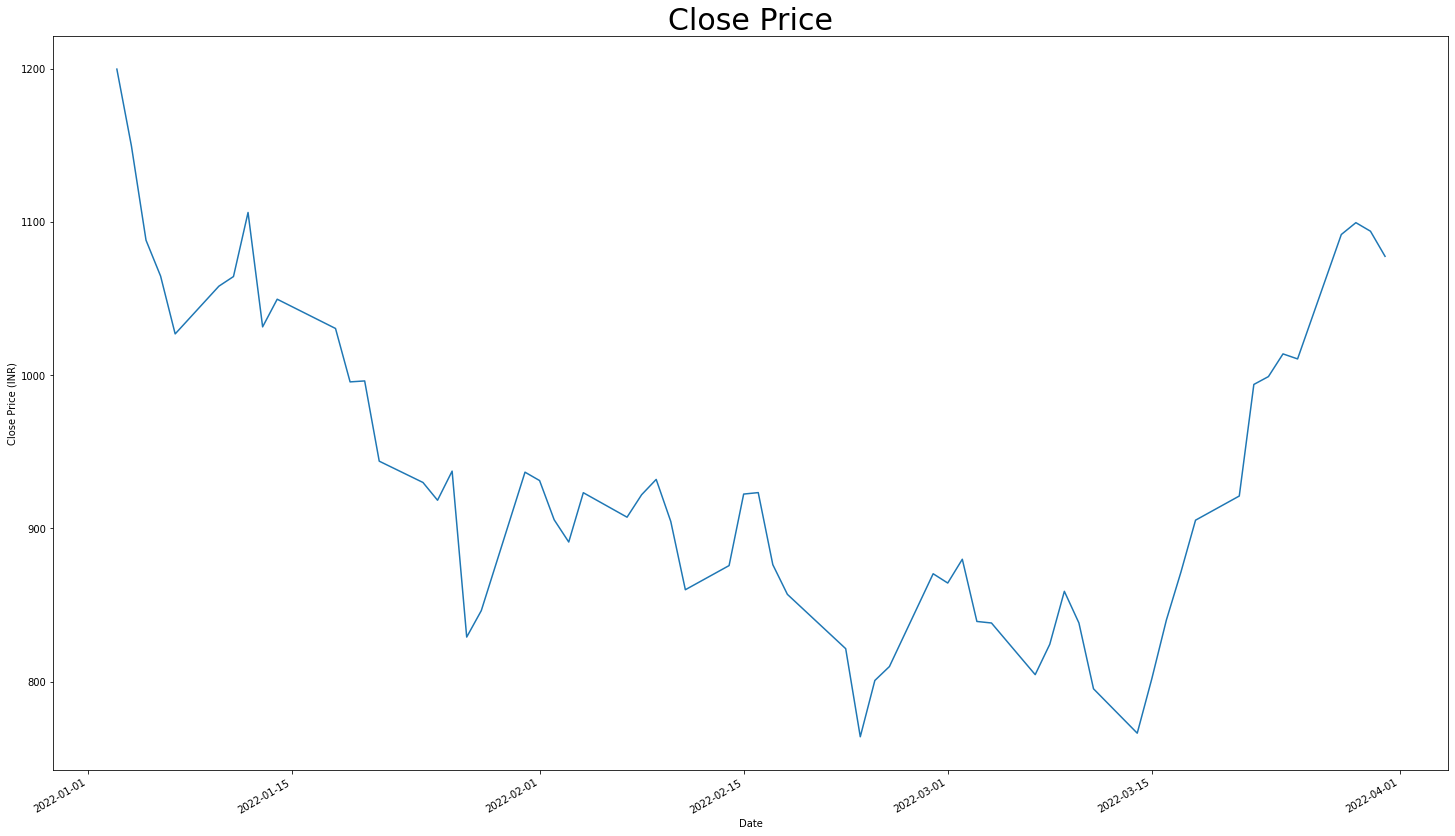

In [74]:
#Setting plot size and labels
plt.figure(figsize=(25,15))

comb_stock_data['Close'].plot()


plt.title("Close Price", size='30')
plt.xlabel('Date')
plt.ylabel('Close Price (INR)')

In [ ]:
# calculating 7 day rolling mean
comb_stock_data.rolling(7).mean().head(20)

In [ ]:
# setting figure size
plt.figure(figsize=(25,15))

# plotting the close price and a 30-day rolling mean of close price
comb_stock_data['Close'].plot()
comb_stock_data.rolling(window=30).mean()['Close'].plot()

In [ ]:
comb_stock_data

# Data for modelling

In [ ]:
# calculating data_to_use
percent_of_data = 1.0
data_to_use = int(percent_of_data*(len(comb_stock_data)-1))

# using 85% of data for training
train_end = int(data_to_use*0.85)
total_data = len(comb_stock_data)
start = total_data - data_to_use

# printing number of records in the training and test datasets
print("No. of records in Training Data:", train_end)
print("No. of records in Test Data:", total_data - train_end)

In [ ]:
# predicting one step ahead
steps_to_predict = 1


close_price = comb_stock_data.iloc[start:total_data,0] #close
compound = comb_stock_data.iloc[start:total_data,1] #compound
negative = comb_stock_data.iloc[start:total_data,2] #negative
neutral = comb_stock_data.iloc[start:total_data,3] #neutral
positive = comb_stock_data.iloc[start:total_data,4] #positive
open_price = comb_stock_data.iloc[start:total_data,5] #open
high = comb_stock_data.iloc[start:total_data,6] #high
low = comb_stock_data.iloc[start:total_data,7] #low
volume = comb_stock_data.iloc[start:total_data,8] #volume

# printing close price
print("Close Price:")
close_price

In [ ]:
# shifting next day close
close_price_shifted = close_price.shift(-1) 

# shifting next day compound
compound_shifted = compound.shift(-1) 

# concatenating the captured training data into a dataframe
dataframe = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)

# setting column names of the revised stock data
dataframe.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']

# dropping nulls
dataframe = dataframe.dropna()    
dataframe.head(10)

In [ ]:
#close price shifted set as the target var
y = dataframe['close_price_shifted']
y

In [ ]:
# setting the features dataset for prediction  
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = dataframe[cols]
x

In [ ]:
# scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

# scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

# displaying the scaled feature dataset and the target variable
x, y

In [ ]:
# preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

# printing the shape of the training and the test datasets
print('No. of rows and columns in Training set X:', X_train.shape, 'and y:', y_train.shape)
print('No. of rows and columns in Test set X:', X_test.shape, 'and y:', y_test.shape)

In [ ]:
#reshaping dataset

print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

In [ ]:
# seed set to achieve consistent and less random predictions
np.random.seed(2016)

# setting the architecture for the data model
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))
model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

# printing the model summary
model.summary()

In [ ]:
model.compile(loss='mse' , optimizer='adam')

# fitting the model using the training dataset
model.fit(X_train, y_train, batch_size=8, epochs=10, verbose=1)